In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Cx7OJ5WfQYE6PuAZrjxE")
project = rf.workspace("ifba").project("iris-gpphd")
version = project.version(1)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...


In [8]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path

# Set paths
images_path = Path('/kaggle/working/iris-1/train')
anno_path = Path('/kaggle/working/iris-1/train')

# Helper function to get file list
def filelist(root, file_type):
    """Generate file list of specific type from the root directory."""
    return [os.path.join(directory_path, f) for directory_path, directory_name, files in os.walk(root) for f in files if f.endswith(file_type)]

# Generate DataFrame from XML annotations
def generate_train_df(anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = os.path.join(images_path, root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

# Create DataFrame
df_train = generate_train_df(anno_path)
class_dict = {'iris': 0}  # Update the dictionary according to new class names
df_train['class'] = df_train['class'].apply(lambda x: class_dict[x])

# Convert columns to correct data types
df_train['filename'] = df_train['filename'].astype(str)
df_train['width'] = df_train['width'].astype(np.float32)
df_train['height'] = df_train['height'].astype(np.float32)
df_train['xmin'] = df_train['xmin'].astype(np.float32)
df_train['ymin'] = df_train['ymin'].astype(np.float32)
df_train['xmax'] = df_train['xmax'].astype(np.float32)
df_train['ymax'] = df_train['ymax'].astype(np.float32)
df_train['class'] = df_train['class'].astype(np.int32)

# Print the DataFrame to verify
df_train.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/kaggle/working/iris-1/train/6_jpg.rf.3dfe4b10...,640.0,640.0,0,222.0,124.0,426.0,532.0
1,/kaggle/working/iris-1/train/22_jpg.rf.560be24...,640.0,640.0,0,224.0,238.0,418.0,514.0
2,/kaggle/working/iris-1/train/52_jpg.rf.6d88bf1...,640.0,640.0,0,232.0,209.0,412.0,455.0
3,/kaggle/working/iris-1/train/132_jpg.rf.7334a3...,640.0,640.0,0,244.0,224.0,462.0,502.0
4,/kaggle/working/iris-1/train/17_jpg.rf.005cc9e...,640.0,640.0,0,207.0,111.0,566.0,502.0


In [9]:
df_train['filename'] = df_train['filename'].astype(str)
df_train['width'] = df_train['width'].astype(np.float32)
df_train['height'] = df_train['height'].astype(np.float32)
df_train['xmin'] = df_train['xmin'].astype(np.float32)
df_train['ymin'] = df_train['ymin'].astype(np.float32)
df_train['xmax'] = df_train['xmax'].astype(np.float32)
df_train['ymax'] = df_train['ymax'].astype(np.float32)
df_train['class'] = df_train['class'].astype(np.int32)  # Assuming class labels are integers

def preprocess(filename, width, height, xmin, ymin, xmax, ymax, class_id):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, [224, 224])
    image_normalized = image_resized / 255.0

    xmin_norm = xmin / width
    ymin_norm = ymin / height
    xmax_norm = xmax / width
    ymax_norm = ymax / height
    bbox = tf.stack([xmin_norm, ymin_norm, xmax_norm, ymax_norm])

    class_one_hot = tf.one_hot(class_id, depth=2)

    return image_normalized, (class_one_hot, bbox)

dataset = tf.data.Dataset.from_tensor_slices((
    df_train['filename'].values, 
    df_train['width'].values, 
    df_train['height'].values, 
    df_train['xmin'].values, 
    df_train['ymin'].values, 
    df_train['xmax'].values, 
    df_train['ymax'].values, 
    df_train['class'].values
))
dataset = dataset.map(preprocess).batch(32)

for image, (label, bbox) in dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())
    print("Bounding box:", bbox.numpy())


Image shape: (27, 224, 224, 3)
Label: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Bounding box: [[0.346875  0.19375   0.665625  0.83125  ]
 [0.35      0.371875  0.653125  0.803125 ]
 [0.3625    0.3265625 0.64375   0.7109375]
 [0.38125   0.35      0.721875  0.784375 ]
 [0.3234375 0.1734375 0.884375  0.784375 ]
 [0.4125    0.26875   0.7421875 0.96875  ]
 [0.4015625 0.39375   0.625     0.85625  ]
 [0.3390625 0.3921875 0.6484375 0.8921875]
 [0.3609375 0.30625   0.6703125 0.696875 ]
 [0.4140625 0.3359375 0.753125  0.8515625]
 [0.3234375 0.315625  0.634375  0.809375 ]
 [0.33125   0.415625  0.5921875 0.771875 ]
 [0.3546875 0.290625  0.6515625 0.7765625]
 [0.375     0.3046875 0.684375  0.8015625]
 [0.3703125 0.2609375 0.6828125 0.7640625]
 [0.3703125 0.2796875 0.653125  0.61875  ]
 [0.2875    0.27

In [10]:
# Load MobileNetV2 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base model if you are fine-tuning
base_model.trainable = False


flatten = Flatten()(base_model.output)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)


class_output = Dense(2, activation='softmax', name='class_output')(dropout)


bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(dropout)  # Sigmoid if coordinates are normalized


model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])


model.compile(
    optimizer='adam',
    loss={
        'class_output': 'categorical_crossentropy',
        'bbox_output': 'mean_squared_error'
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mse'
    }
)


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 10,287,046 (39.24 MB)

 Trainable params: 8,029,062 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - bbox_output_mse: 0.1776 - class_output_accuracy: 1.0000 - loss: 0.1776
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - bbox_output_mse: 0.1686 - class_output_accuracy: 1.0000 - loss: 0.1686
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - bbox_output_mse: 0.1607 - class_output_accuracy: 1.0000 - loss: 0.1607
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - bbox_output_mse: 0.1805 - class_output_accuracy: 1.0000 - loss: 0.1805
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - bbox_output_mse: 0.1742 - class_output_accuracy: 1.0000 - loss: 0.1742
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - bbox_output_mse: 0.1591 - class_output_accuracy: 1.0000 - loss: 0.1591
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step - bbox_output_mse: 0.1475 - class_output_accuracy: 1.0000 - loss: 0.1475
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - bbox_output_mse: 0.1778 - class_output_accuracy: 1.0000 - loss: 0.1778
Epoch 9/10
1/1 ━

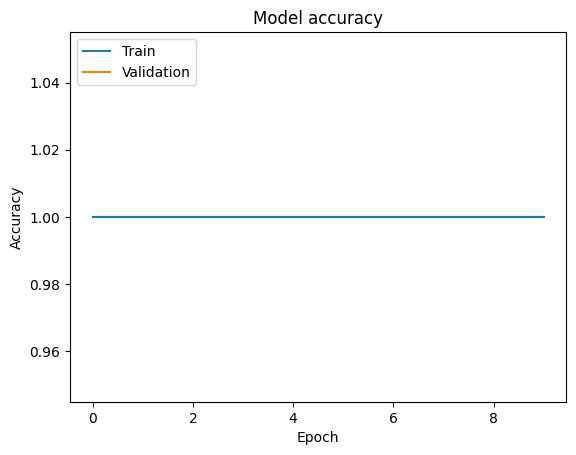

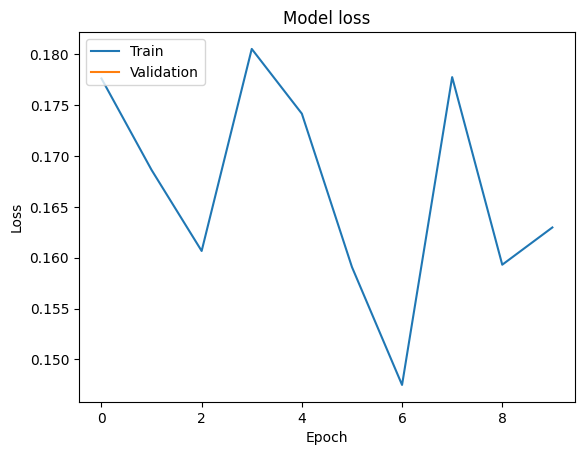

In [13]:
# Train the model
history = model.fit(
    dataset,  # The dataset you prepared earlier
    epochs=10
)

#Visualize Training
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history.get('val_class_output_accuracy', []))  # If validation accuracy is available
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history.get('val_loss', []))  # If validation loss is available
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model.save('./model.h5')

In [14]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  
    img /= 255.0  # Normalize to [0, 1]
    return img

In [19]:
def draw_bbox(image, bbox, class_id, class_confidence):
    text = 'eye'
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.text(xmin, ymin, f'{text} ({class_confidence:.2f})', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    print(text)
    plt.axis('off')
    plt.show()


In [20]:
def predict_image(image_path, model):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    original_img = load_img(image_path)  # Load original image for visualization

    # Predict
    predictions = model.predict(img)
    class_preds, bbox_preds = predictions

    # Class prediction
    class_id = np.argmax(class_preds[0])
    class_confidence = np.max(class_preds[0])

    # Bbox prediction (assuming bbox is normalized [xmin, ymin, xmax, ymax])
    xmin, ymin, xmax, ymax = bbox_preds[0]
    width, height = original_img.size
    bbox = [xmin * width, ymin * height, xmax * width, ymax * height]  # Scale bbox to original image size

    # Draw bbox on the image
    draw_bbox(np.array(original_img), bbox, class_id, class_confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
eye


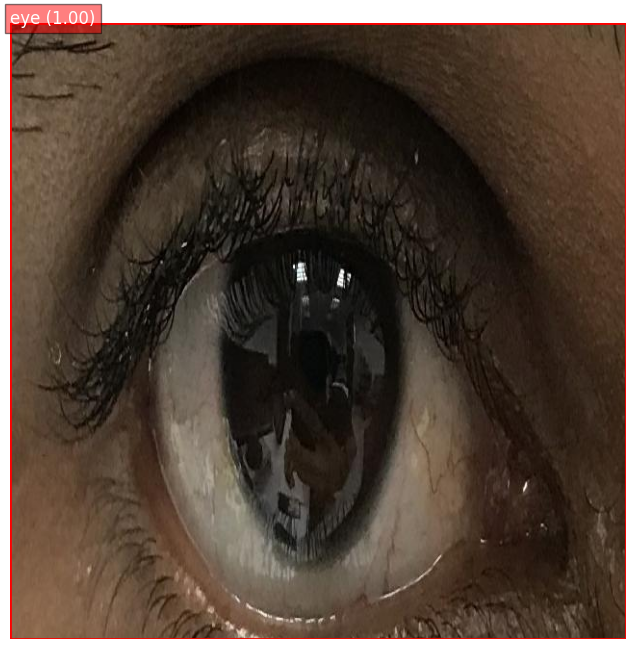

In [24]:
model_path = '/kaggle/working/model.h5'
model = tf.keras.models.load_model(model_path)
image_path = '/kaggle/working/iris-1/train/15_jpg.rf.79e032223f430f38ee2baad90f5e50d5.jpg'
predict_image(image_path, model)